In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Sapienza/DL

/content/drive/MyDrive/Sapienza/DL


In [3]:
import pickle
import pandas as pd
import numpy as np
import json
import itertools
import gensim
path="SEMEVAL-2021-task6-corpus/data/"


In [4]:
with open('training_task1_labels.pkl', 'rb') as handle:
    train_labs = pickle.load(handle)

with open('original_training_task1_features.pkl', 'rb') as handle:
    train_feats = pickle.load(handle)

with open('training_task1_all_labels.pkl', 'rb') as handle:
    all_labels = pickle.load(handle)

with open('dev_task1_labels.pkl', 'rb') as handle:
    dev_labs = pickle.load(handle)

with open('original_dev_task1_features.pkl', 'rb') as handle:
    dev_feats = pickle.load(handle)

with open('test_task1_labels.pkl', 'rb') as handle:
    test_labs = pickle.load(handle)

with open('original_test_task1_features.pkl', 'rb') as handle:
    test_feats = pickle.load(handle)


In [5]:
import tensorflow as tf
print(tf.version.VERSION)

2.8.0


In [6]:
#!git clone --depth 1 -b v2.4.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 752, done.
remote: Counting objects: 100% (752/752), done.
remote: Compressing objects: 100% (651/651), done.
remote: Total 752 (delta 166), reused 372 (delta 91), pack-reused 0
Receiving objects: 100% (752/752), 1.22 MiB | 4.22 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Note: checking out '47e65c1aedf4181faaf5535f06c26dbcb083c4ad'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Checking out files: 100% (693/693), done.


In [6]:
!pip3 install -Uqr models/official/requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.8.0 requires pyyaml<6.0,>=5.1, but you have pyyaml 6.0 which is incompatible.


In [10]:
!pip3 install tf-models-official


     |████████████████████████████████| 2.2 MB 8.1 MB/s 
     |████████████████████████████████| 90 kB 12.7 MB/s 
     |████████████████████████████████| 4.9 MB 47.0 MB/s 
     |████████████████████████████████| 636 kB 58.9 MB/s 
     |████████████████████████████████| 462 kB 73.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [8]:
!ls

bert2.ipynb			      original_training_task2_labels1.pkl
cnn.ipynb			      original_training_task2_labels2.pkl
dev_task1_all_labels.pkl	      SEMEVAL-2021-task6-corpus
dev_task1_features.pkl		      task1_tfidf.ipynb
dev_task1_features_w2v.pkl	      task2_all_labels.pkl
dev_task1_labels.pkl		      task2_labels_dict.pkl
FT_bert_task1.ipynb		      tensorboard_data
get_data2.ipynb			      test_dev_task1_features.pkl
get_data.ipynb			      test_task1_all_labels.pkl
logR.ipynb			      test_task1_features.pkl
lstm_task2.ipynb		      test_task1_features_w2v.pkl
models				      test_task1_labels.pkl
original_dev_task1_features.pkl       tfidf_logR_task1.ipynb
original_dev_task2_features.pkl       training_task1_all_labels.pkl
original_dev_task2_labels1.pkl	      training_task1_features.pkl
original_dev_task2_labels2.pkl	      training_task1_features_w2v.pkl
original_test_task1_features.pkl      training_task1_labels.pkl
original_training_task1_features.pkl  trans1.ipynb
original_training_task1_l

In [7]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
#sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [8]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [10]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_feats, train_labs))
    valid_data = tf.data.Dataset.from_tensor_slices((dev_feats, dev_labs))
    # lets look at 3 samples from train set
    for text,label in train_data.take(3):
        print(text)
        print(label)

tf.Tensor(b'THERE ARE ONLY TWO GENDERS FEMALE  MALE', shape=(), dtype=string)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(23,), dtype=float64)
tf.Tensor(b'This is not an accident!', shape=(), dtype=string)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(23,), dtype=float64)
tf.Tensor(b'SO BERNIE BROS HAVENT COMMITTED VIOLENCE EH? POWER COMES FROM THE BARREL OF A GUN, COMRADES. WHAT ABOUT THE ONE WHO SHOT CONGRESSMAN SCALISE OR THE DAYTON OHIO MASS SHOOTER?', shape=(), dtype=string)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.], shape=(23,), dtype=float64)


In [11]:
print(len(train_data))
print(len(valid_data))

688
63


In [35]:
config = {'label_list' : np.arange(21).tolist(), # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 8,
          'learning_rate': 2e-5,
          'epochs':5,
          'optimizer': 'adam',
          'dropout': 0.5,
          'train_samples': len(train_data),
          'valid_samples': len(valid_data),
          'train_split':0.1,
          'valid_split': 0.01
         }

In [36]:
config

{'dropout': 0.5,
 'epochs': 5,
 'label_list': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'learning_rate': 2e-05,
 'max_seq_length': 128,
 'optimizer': 'adam',
 'train_batch_size': 8,
 'train_samples': 172,
 'train_split': 0.1,
 'valid_samples': 15,
 'valid_split': 0.01}

In [13]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [14]:
input_string = "hello world, it is a wonderful day for learning"
print(tokenizer.wordpiece_tokenizer.tokenize(input_string))
print(tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(input_string)))

['hello', 'world', '##,', 'it', 'is', 'a', 'wonderful', 'day', 'for', 'learning']
[7592, 2088, 29623, 2009, 2003, 1037, 6919, 2154, 2005, 4083]


In [37]:
def create_feature(text, label, label_list=config['label_list'], max_seq_length=config['max_seq_length'], tokenizer=tokenizer):
    """
    converts the datapoint into usable features for BERT using the classifier_data_lib

    Parameters:
    text: Input text string
    label: label associated with the text
    label_list: (list) all possible labels
    max_seq_length: (int) maximum sequence length set for bert
    tokenizer: the tokenizer object instantiated by the files in model assets

    Returns:
    feature.input_ids: The token ids for the input text string
    feature.input_masks: The padding mask generated 
    feature.segment_ids: essentially here a vector of 0s since classification
    feature.label_id: the corresponding label id from lable_list [0, 1] here

    """
    # since we only have 1 sentence for classification purpose, textr_b is None
    example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
    # since only 1 example, the index=0
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [38]:
def create_feature_map(text, label):
    """
    A tensorflow function wrapper to apply the transformation on the dataset.
    Parameters:
    Text: the input text string.
    label: the classification ground truth label associated with the input string

    Returns:
    A tuple of a dictionary and a corresponding label_id with it. The dictionary 
    contains the input_word_ids, input_mask, input_type_ids  
    """
    input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    max_seq_length = config['max_seq_length']

    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)

In [39]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(create_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

                          .shuffle(1000)
                          .batch(4, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(4, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

TypeError: ignored

In [18]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(4,), dtype=tf.int32, name=None))

In [30]:
def create_model():
    
    input_word_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32,
                                   name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32,
                                    name="input_type_ids")


    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    # for classification we only care about the pooled-output
    # at this point we can play around with the classification head based on the downstream tasks and its complexity

    drop = tf.keras.layers.Dropout(config['dropout'])(pooled_output)
    output = tf.keras.layers.Dense(21, activation='sigmoid', name='output')(drop)

    # inputs coming from the function
    model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}, 
      outputs=output)

    return model

In [31]:
model = create_model()

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy(),
                       tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',       

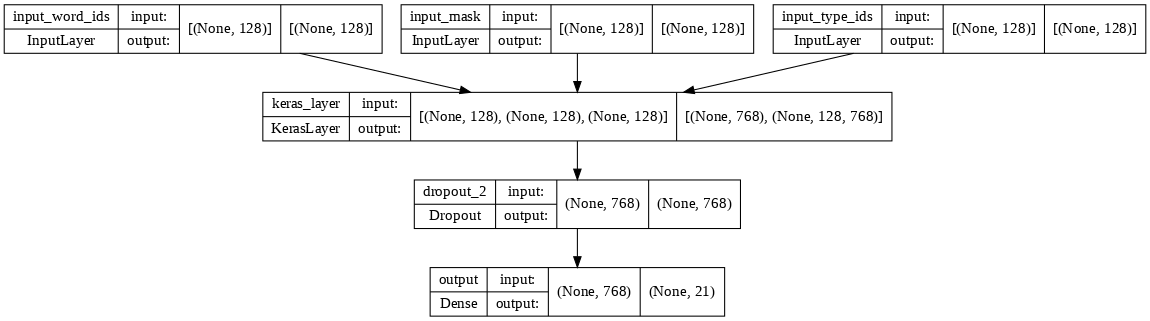

In [33]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [34]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=2,
                    verbose=1)

Epoch 1/2


ValueError: ignored